In [1]:
# data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# data prep
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# keras utilities for RNN model
from keras.models import load_model
from keras.callbacks import EarlyStopping 
from keras.models import Sequential
from keras.layers import Dense, Dropout, ConvLSTM2D, LSTM, Activation

In [4]:
# exploring the provided files
import os
import pandas as pd

# Assuming your current working directory is the one containing your datasets
# Update the directory path to where your datasets are located
directory_path = 'C:/Users/David Agogo/Documents/Personal Projects/Prognosis'

# Exploring the provided files in the updated directory
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Update the paths for reading the train and test CSV files
train_df = pd.read_csv(os.path.join(directory_path, "Train_Data_CSV.csv"))
test_df = pd.read_csv(os.path.join(directory_path, "Test_Data_CSV.csv"))

# Correcting the column order as per your requirement
train_df.columns = ["Data_No","Differential_pressure","Flow_rate","Time","Dust_feed","RUL","Sampling","Bias_type"]
train_df = train_df[["Data_No","Differential_pressure","Flow_rate","Time","Dust_feed","Sampling","RUL","Bias_type"]]

# Printing the first few rows of the dataframes
print(train_df.head().to_markdown(index=False), end="\n\n")
print(test_df.head().to_markdown(index=False))


C:/Users/David Agogo/Documents/Personal Projects/Prognosis\Data.mat
C:/Users/David Agogo/Documents/Personal Projects/Prognosis\Particel_size_distribution_ISO_12103_1_A3_Medium_PTI_ID_Data_Quality.mat
C:/Users/David Agogo/Documents/Personal Projects/Prognosis\Prognosis based on Varying Data Quality Data Set.pdf
C:/Users/David Agogo/Documents/Personal Projects/Prognosis\Test_Data_CSV.csv
C:/Users/David Agogo/Documents/Personal Projects/Prognosis\Train_Data_CSV.csv
|   Data_No |   Differential_pressure |   Flow_rate |   Time |   Dust_feed |   Sampling |   RUL | Bias_type   |
|----------:|------------------------:|------------:|-------:|------------:|-----------:|------:|:------------|
|         1 |                11.0178  |     34.5004 |    0.1 |     177.313 |         10 | 131.1 | b           |
|         1 |                 0       |     61.5364 |    0.2 |     177.313 |         10 | 131   | b           |
|         1 |                 4.05526 |     72.3324 |    0.3 |     177.313 |         

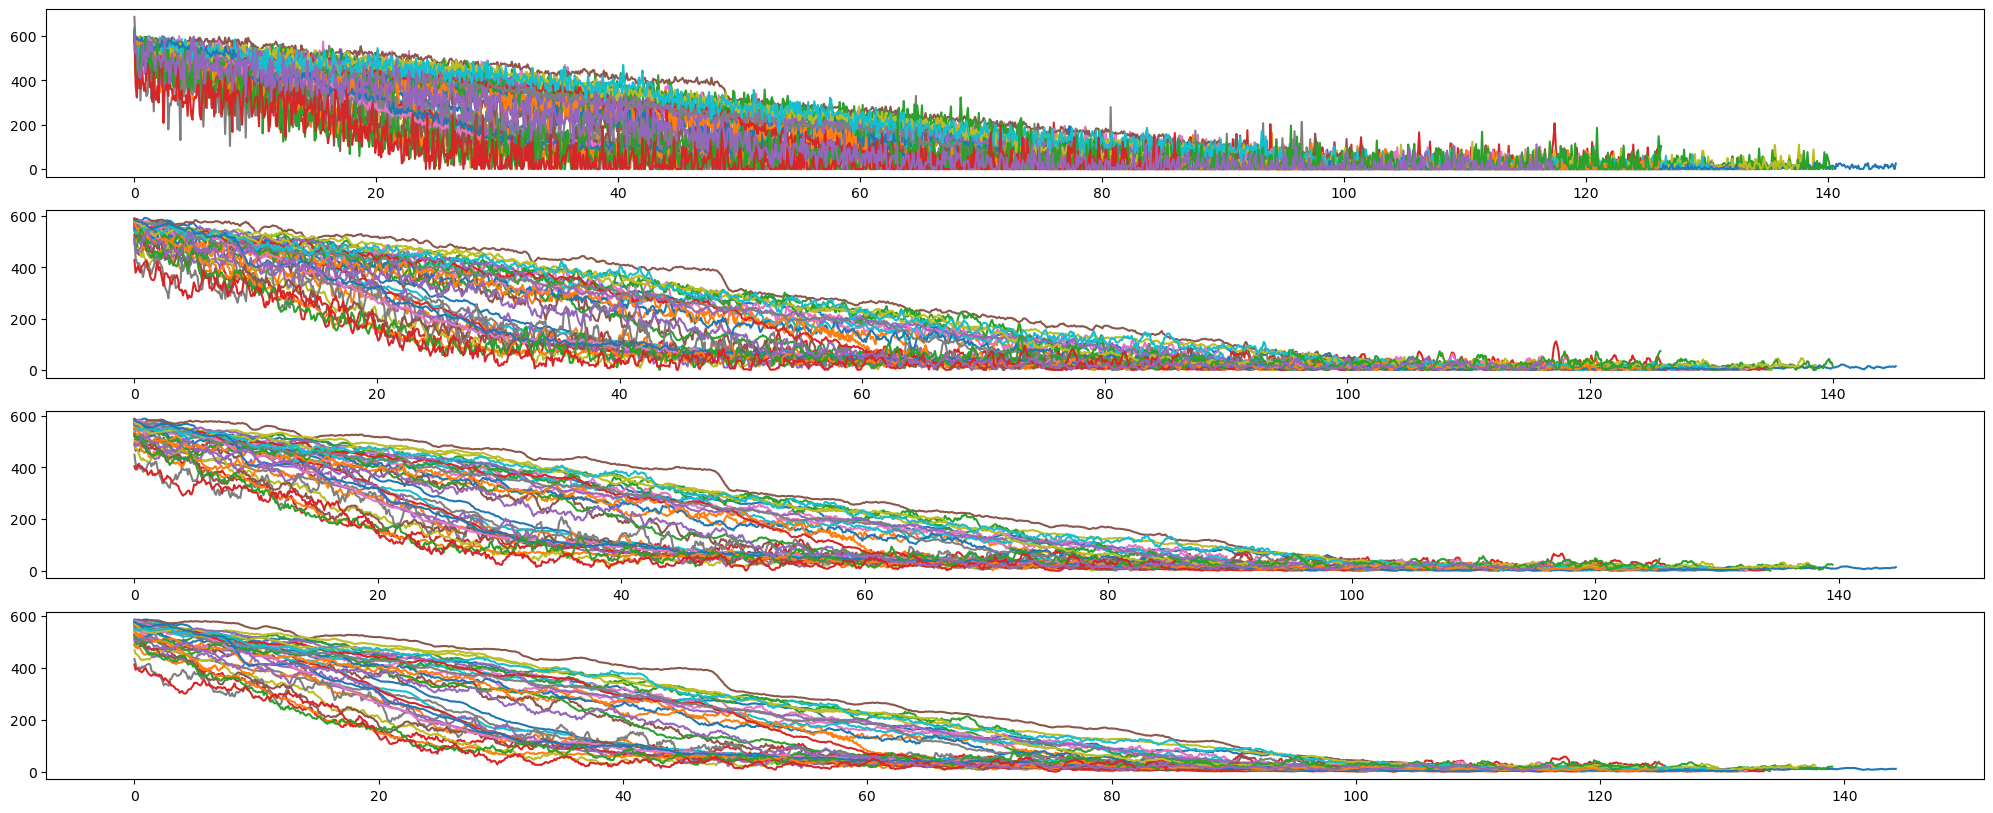

In [5]:
fig, ax = plt.subplots(4,1, figsize=(25,10))
for data_no, df in train_df.groupby('Data_No'):
    ax[0].plot(df['RUL'], df['Differential_pressure'])
    ax[1].plot(df['RUL'], df['Differential_pressure'].rolling(5).mean())
    ax[2].plot(df['RUL'], df['Differential_pressure'].rolling(10).mean())
    ax[3].plot(df['RUL'], df['Differential_pressure'].rolling(15).mean())

(0.0, 0.4)

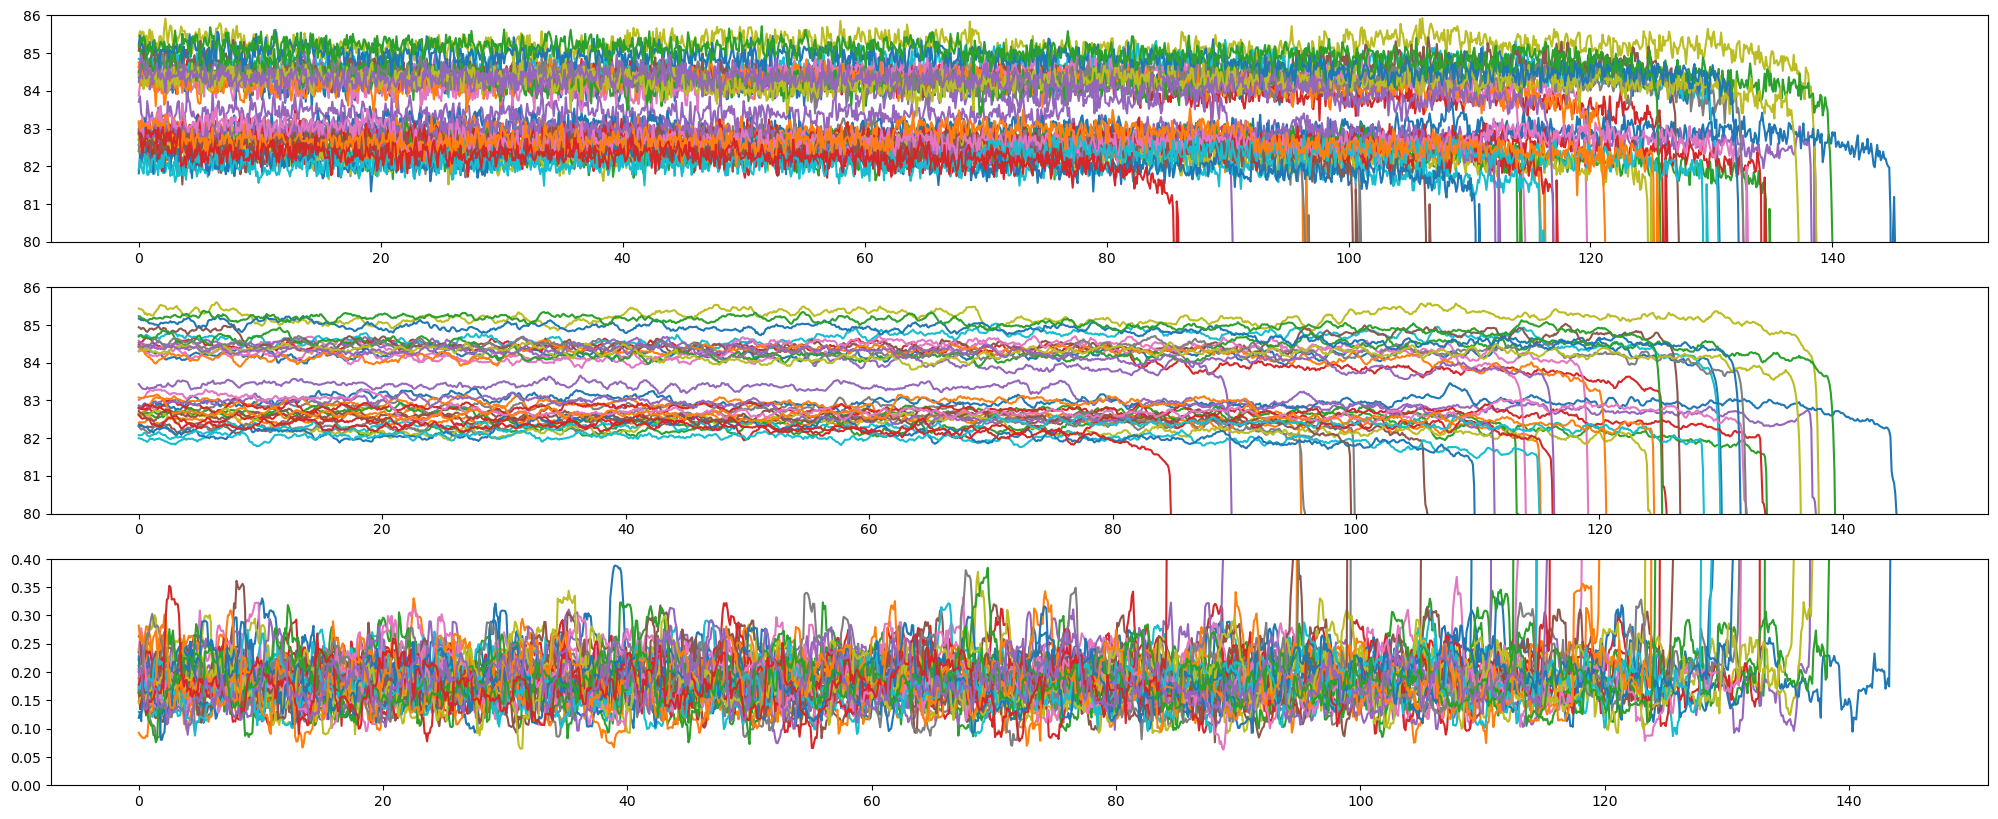

In [6]:
fig, ax = plt.subplots(3,1, figsize=(25,10))
for data_no, df in train_df.groupby('Data_No'):
    ax[0].plot(df['RUL'], df['Flow_rate'])
    ax[1].plot(df['RUL'], df['Flow_rate'].rolling(10).mean())
    ax[2].plot(df['RUL'], df['Flow_rate'].rolling(15).std())
for a in ax[:-1]:
    a.set_ylim(80,86)
ax[2].set_ylim(0,0.4)

The flow rate exhibits minimal variation during the central part of our observation period. Initially, it begins at zero but swiftly rises and stabilizes at approximately 83 or 85 counts. Given the signal's stability throughout the observation, it is unlikely to significantly influence our model.

Moving on to Dust_feed, this attribute presents intriguing characteristics due to its limited range of only three possible values. Dust_feed appears to play a role in determining the Remaining Useful Life (RUL), as the


<Axes: >

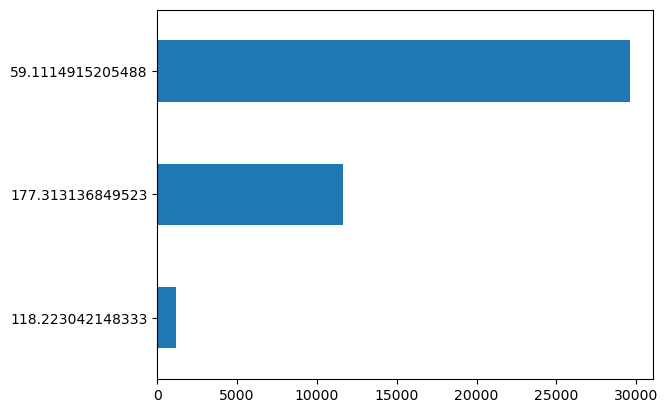

In [7]:
train_df['Dust_feed'].value_counts(ascending=True).plot(kind='barh')

C:\Users\David Agogo\AppData\Local\Temp\ipykernel_43556\4001484576.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for a, (name, df) in enumerate(train_df.groupby(['Dust_feed'])):


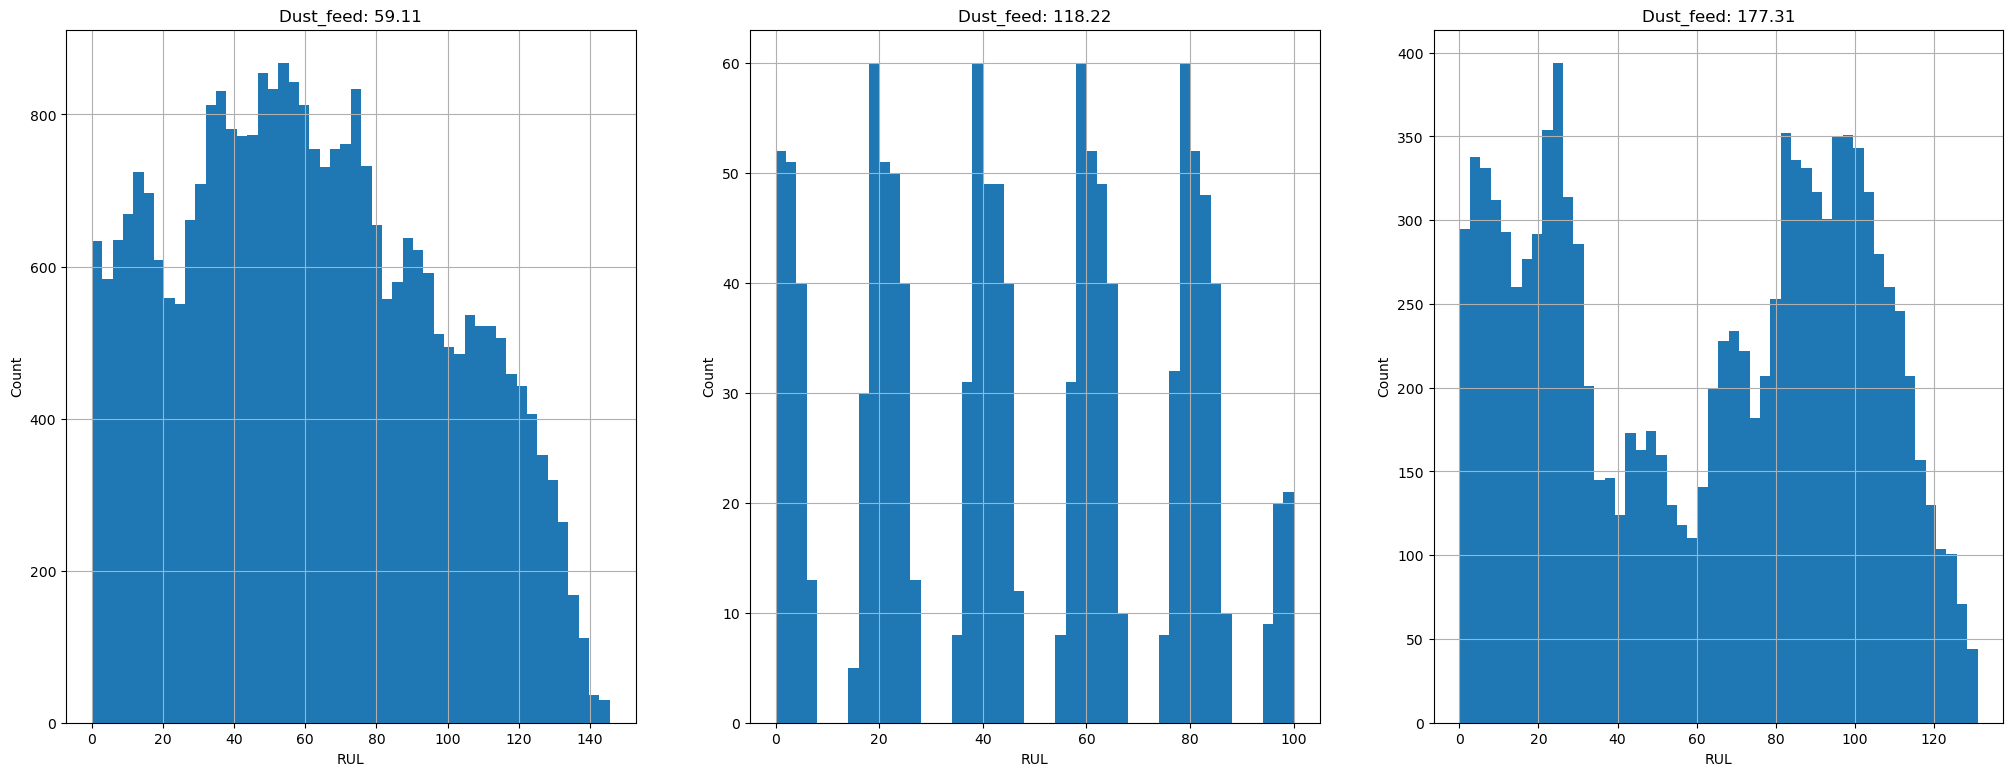

In [8]:
fig,ax = plt.subplots(1,3, figsize=(25,9))
for a, (name, df) in enumerate(train_df.groupby(['Dust_feed'])):
    df['RUL'].hist(bins = 50, ax = ax[a])
    ax[a].set_title(f"Dust_feed: {name:.2f}")
    ax[a].set_xlabel("RUL")
    ax[a].set_ylabel("Count")

The sampling rate, presumably measured in Hertz, remains constant at 10 throughout all observations. This consistency can be confirmed by examining the data collection records in our observations.

In [9]:
(1/train_df['Sampling']).value_counts() == train_df.groupby('Data_No')['Time'].diff().bfill().round(10).value_counts()

0.1    True
dtype: bool

In [10]:
train_df['Bias_type']

0        b
1        b
2        b
3        b
4        b
        ..
42435    d
42436    d
42437    d
42438    d
42439    d
Name: Bias_type, Length: 42440, dtype: object

## Constructing the Recurrent Neural Network (RNN)

An RNN is a type of neural network that incorporates prior observations into its input, making it particularly suited for sequential data analysis. For this model, the input will be two-dimensional, incorporating the last 'n' observations. In this instance, we will utilize the most recent 20 observations as predictors for our model. The target variable will be the Remaining Useful Life (RUL) determined after these 'n' observations. To prepare our data for the RNN, we will employ the following functions to appropriately reshape it.

In [11]:
def x_reshape(df, columns, sequence_length):
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, 
                                 num_elements-sequence_length), 
                           range(sequence_length,
                                 num_elements)):
        yield(data[start:stop, :])

def get_x_slices(df, feature_columns):
    # Reshape the data to (samples, time steps, features)
    feature_list = [list(x_reshape(df[df['Data_No'] == i], feature_columns, 100)) 
                    for i in range(1, df['Data_No'].nunique() + 1) if len(df[df['Data_No']  == i]) > 100]
    feature_array = np.concatenate(list(feature_list), axis=0).astype(np.float64)

    length = len(feature_array) // 128
    return feature_array[:length*128]

def get_data_id(df):
    label_list = [y_reshape(df[df['Data_No'] == i], 100, columns  = ['Data_No']) 
                  for i in range(1, df['Data_No'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.int64)
    length = len(label_array) // 128
    return label_array[:length* 128]

def y_reshape(df, sequence_length, columns=['RUL']):
    data = df[columns].values
    num_elements = data.shape[0]
    return(data[sequence_length:num_elements, :])
        
def get_y_slices(df):
    label_list = [y_reshape(df[df['Data_No'] == i], 100) 
                  for i in range(1, df['Data_No'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.float64)
    length = len(label_array) // 128
    return label_array[:length*128]

In [12]:
scaler = MinMaxScaler()
X_train = get_x_slices(train_df, ['Differential_pressure','Flow_rate','Time','Dust_feed'])
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = get_x_slices(test_df,['Differential_pressure','Flow_rate','Time','Dust_feed'])
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train = get_y_slices(train_df)
y_test = get_y_slices(test_df)
assert(y_train.shape[0] == X_train.shape[0])
assert(y_test.shape[0] == X_test.shape[0])

In [13]:
model = Sequential()
model.add(LSTM(input_shape=(X_train.shape[1], 
                            X_train.shape[2]), 
               units=10, 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30, 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=25, 
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Dropout(0.2))
model.add(Activation("linear"))

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['mse','mae'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 10)           600       
                                                                 
 dropout (Dropout)           (None, 100, 10)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           12200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 30)           9720      
                                                                 
 dropout_2 (Dropout)         (None, 100, 30)           0         
                                                                 
 lstm_3 (LSTM)               (None, 25)                5

In [15]:
es = EarlyStopping(monitor='val_mae',  
                   patience=5, 
                   verbose=True)

In [16]:
history = model.fit(X_train,
                    y_train,
                    epochs=999, 
                    validation_data=(X_test, 
                                     y_test), 
                    callbacks=[es])

Epoch 1/999


1216/1216 [==============================] - 161s 127ms/step - loss: 2636.5886 - mse: 2636.5886 - mae: 41.6588 - val_loss: 2060.7207 - val_mse: 2060.7207 - val_mae: 37.9233
Epoch 2/999
1216/1216 [==============================] - 157s 129ms/step - loss: 1865.7996 - mse: 1865.7996 - mae: 35.1051 - val_loss: 1370.2578 - val_mse: 1370.2578 - val_mae: 29.9973
Epoch 3/999
1216/1216 [==============================] - 156s 128ms/step - loss: 1806.9188 - mse: 1806.9188 - mae: 34.6471 - val_loss: 1287.7156 - val_mse: 1287.7156 - val_mae: 29.0417
Epoch 4/999
1216/1216 [==============================] - 152s 125ms/step - loss: 1811.9628 - mse: 1811.9628 - mae: 34.6943 - val_loss: 1277.7130 - val_mse: 1277.7130 - val_mae: 28.9258
Epoch 5/999
1216/1216 [==============================] - 161s 132ms/step - loss: 1800.2977 - mse: 1800.2977 - mae: 34.6073 - val_loss: 1286.8413 - val_mse: 1286.8413 - val_mae: 29.0316
Epoch 6/999
1216/1216 [==============================] - 151s 124ms/step 

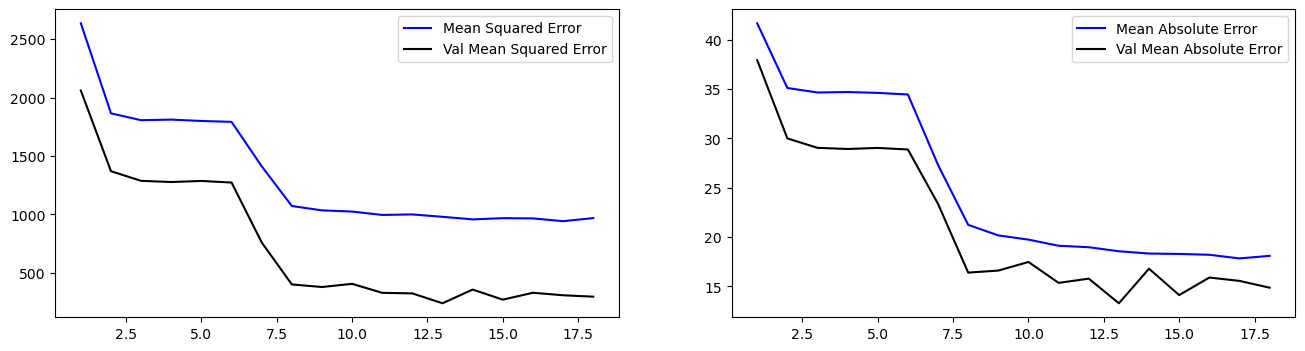

In [17]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,4))

ax1.plot(np.arange(1,
                   len(history.history['loss']) + 1), 
         history.history['loss'], 
         color = 'blue', 
         label = 'Mean Squared Error')

ax1.plot(np.arange(1,
                   len(history.history['val_loss']) + 1), 
         history.history['val_loss'], 
         color = 'black', 
         label = 'Val Mean Squared Error')
ax1.legend()

ax2.plot(np.arange(1,
                   len(history.history['mae']) + 1), 
         history.history['mae'], 
         color = 'blue', 
         label = 'Mean Absolute Error')

ax2.plot(np.arange(1,
                   len(history.history['val_mae']) + 1), 
         history.history['val_mae'], 
         color = 'black', 
         label = 'Val Mean Absolute Error')
ax2.legend();

In [18]:
pred = model.predict(X_test)

524/524 [==============================] - 25s 45ms/step


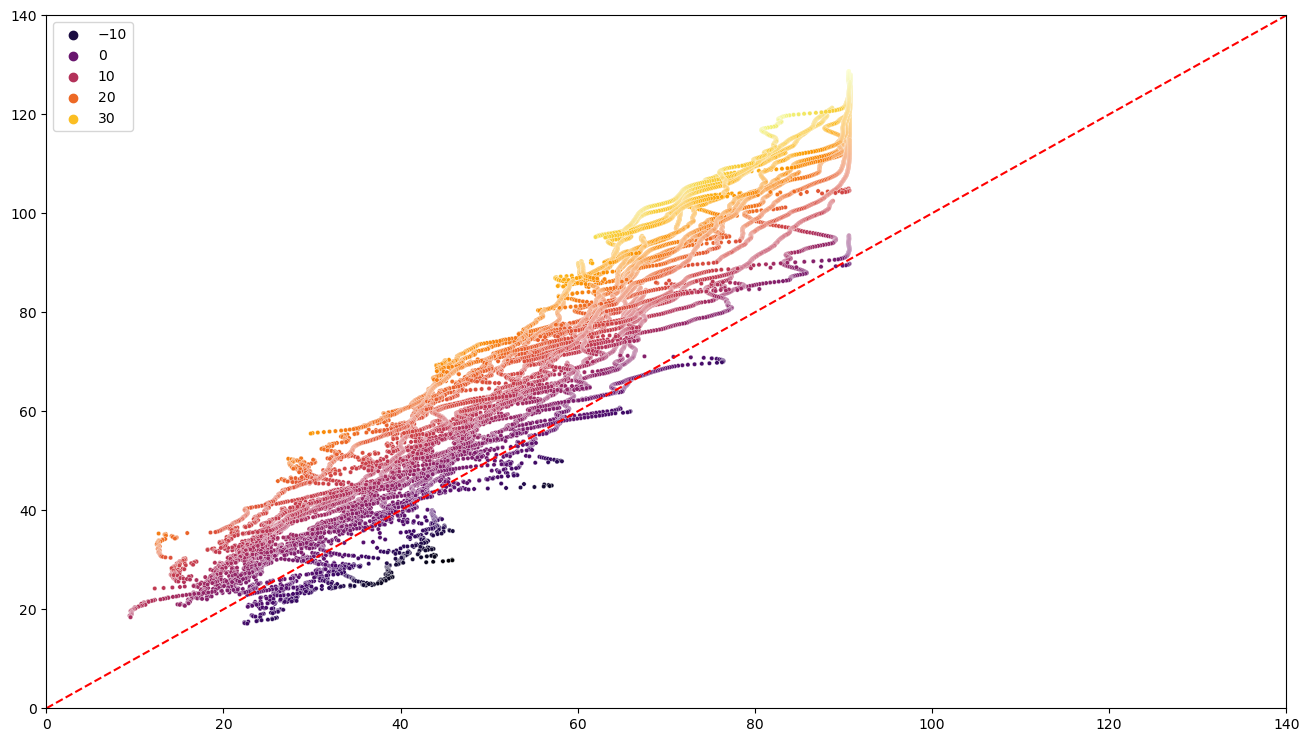

In [19]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = pred.reshape(1,-1)[0], 
                y = y_test.reshape(1,-1)[0], 
                hue = y_test.reshape(1,-1)[0] - pred.reshape(1,-1)[0], 
                palette='inferno', 
                s = 10)
plt.xlim(0,140)
plt.ylim(0,140)
plt.plot([0,140], [0,140], linestyle="--", color = 'red')

Model Performance: The RNN model, with its sequence of LSTM layers and dropout regularization, shows promising results in predicting RUL based on historical sensor data. The use of early stopping based on validation mean absolute error (MAE) suggests the model is capable of generalizing well without overfitting.

Impact of Data Quality: The varying data quality, represented through different signal-to-noise ratios (SNR) and bias levels, poses a significant challenge. However, the model's ability to predict RUL despite these variations indicates that it has learned to extract relevant features from the noisy data effectively. This underscores the importance of robust preprocessing and model architecture to handle real-world data complexities.

Importance of Historical Data: Utilizing the last 20 observations as input features highlights the significance of temporal data in understanding and predicting equipment health. This reinforces the concept that patterns in historical sensor readings are vital for accurate prognostics.

Potential for Maintenance Optimization: The model's capability to predict RUL with reasonable accuracy presents a substantial opportunity to optimize maintenance schedules. By accurately forecasting when maintenance should be performed, organizations can avoid unnecessary downtime and extend the lifespan of their equipment.

Need for Further Validation: While the model shows promise, further validation on additional datasets and in real-world scenarios is necessary to fully understand its capabilities and limitations. This includes testing the model's performance across a wider range of equipment types, operational conditions, and failure modes.

Integration of Physical Models: The context mentions the possibility of enhancing data-driven models with physical knowledge or models. This interdisciplinary approach could further improve the accuracy of RUL predictions by incorporating domain-specific insights into the machine learning process.

Contribution to PHM Research: The dataset and the RNN model's development contribute valuable insights to the PHM field, particularly in addressing the challenges posed by varying data quality. This work underscores the potential of machine learning in advancing predictive maintenance strategies.

In summary, the RNN model's development and its results on the provided dataset demonstrate the feasibility and potential benefits of using machine learning for predictive maintenance in PHM applications. The findings suggest that with careful consideration of data quality and model design, machine learning can be a powerful tool in predicting equipment failure and optimizing maintenance schedules.